# Dogecoin Project

In this notebook, we create a multiple linear regression model to predict the price of Dogecoin from 2/24/2021 to 11/19/2021.

# Part 1: Data Preparation

In [1]:
# Import libraries
import os
import re
import numpy as np
import pandas as pd

# Define path variables
raw_dir = '..\\data\\raw'
processed_dir = '..\\data/processed'

In [2]:
# Create prices dataframe
prices = pd.read_csv(os.path.join(raw_dir, 'dogecoin_prices.csv'))
prices.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,DOGE,2021-02-24,0.056001,0.047662,0.060673,0.045988
1,DOGE,2021-02-25,0.051987,0.056834,0.057943,0.050511
2,DOGE,2021-02-26,0.050215,0.049972,0.052641,0.048510
3,DOGE,2021-02-27,0.050144,0.050492,0.052032,0.049578
4,DOGE,2021-02-28,0.048988,0.050210,0.050322,0.044827


In [3]:
# Clean prices dataframe
prices.rename(columns={'Date':'date','24h Open (USD)':'open',
                       'Closing Price (USD)':'close', '24h High (USD)': 'high',
                       '24h Low (USD)': 'low'}, inplace=True)
prices['date'] = prices['date'].astype('datetime64')
prices = prices.drop(columns=['Currency'])
prices = prices[['date', 'open', 'high', 'low', 'close']]
prices.head()

,date,open,high,low,close
0,2021-02-24,0.047662,0.060673,0.045988,0.056001
1,2021-02-25,0.056834,0.057943,0.050511,0.051987
2,2021-02-26,0.049972,0.052641,0.048510,0.050215
3,2021-02-27,0.050492,0.052032,0.049578,0.050144
4,2021-02-28,0.050210,0.050322,0.044827,0.048988


In [4]:
prices.dtypes

date     datetime64[ns]
open            float64
high            float64
low             float64
close           float64
dtype: object

In [5]:
# Create Google Trends dataframe
gtrends = pd.read_csv(os.path.join(raw_dir, 'google_trends_data.csv'))
gtrends.head()

,Day,Dogecoin: (Worldwide)
0,2021-02-24,6
1,2021-02-25,5
2,2021-02-26,4
3,2021-02-27,3
4,2021-02-28,3


In [6]:
# Clean Google Trends dataframe
gtrends.rename(columns={'Day':'date', 'Dogecoin: (Worldwide)':'google_trend'}, inplace=True)
gtrends['date'] = gtrends['date'].astype('datetime64')
gtrends.head()

,date,google_trend
0,2021-02-24,6
1,2021-02-25,5
2,2021-02-26,4
3,2021-02-27,3
4,2021-02-28,3


In [7]:
gtrends.dtypes

date            datetime64[ns]
google_trend             int64
dtype: object

In [8]:
# Read text file with social sentiment data
with open(os.path.join(raw_dir, 'social_sentiment.txt')) as file:
    ss = file.readlines()
ss[:30]

['275: {date: "2021-02-24", telegram: {neutral: 7, negative: 0, positive: 25},…}\n',
 'date: "2021-02-24"\n',
 'telegram: {neutral: 7, negative: 0, positive: 25}\n',
 'negative: 0\n',
 'neutral: 7\n',
 'positive: 25\n',
 'twitter: {neutral: 9312, negative: 501, positive: 2869}\n',
 'negative: 501\n',
 'neutral: 9312\n',
 'positive: 2869\n',
 '276: {date: "2021-02-25", telegram: {neutral: 11, negative: 2, positive: 23},…}\n',
 'date: "2021-02-25"\n',
 'telegram: {neutral: 11, negative: 2, positive: 23}\n',
 'negative: 2\n',
 'neutral: 11\n',
 'positive: 23\n',
 'twitter: {neutral: 8256, negative: 383, positive: 2311}\n',
 'negative: 383\n',
 'neutral: 8256\n',
 'positive: 2311\n',
 '277: {date: "2021-02-26", telegram: {neutral: 23, negative: 1, positive: 16},…}\n',
 'date: "2021-02-26"\n',
 'telegram: {neutral: 23, negative: 1, positive: 16}\n',
 'negative: 1\n',
 'neutral: 23\n',
 'positive: 16\n',
 'twitter: {neutral: 5753, negative: 319, positive: 1908}\n',
 'negative: 319\n',
 'neut

In [9]:
# Create numeric filter
def numeric_filter(str):
    return re.sub('[^-0123456789]', '', str)

test_string_1 = 'date: "2021-02-24"\n'
test_string_2 = 'negative: 9312'

print(numeric_filter(test_string_1))
print(numeric_filter(test_string_2))

2021-02-24
9312


In [10]:
# Create lists with social sentiment data
date = []
te_neg, te_neu, te_pos = [], [], []
tw_neg, tw_neu, tw_pos = [], [], []

i = 0
while i < len(ss):
    d = numeric_filter(ss[i+1])
    date.append(d)
    te1 = int(numeric_filter(ss[i+3]))
    te_neg.append(te1)
    te2 = int(numeric_filter(ss[i+4]))
    te_neu.append(te2)
    te3 = int(numeric_filter(ss[i+5]))
    te_pos.append(te3)
    tw1 = int(numeric_filter(ss[i+7]))
    tw_neg.append(tw1)
    tw2 = int(numeric_filter(ss[i+8]))
    tw_neu.append(tw2)
    tw3 = int(numeric_filter(ss[i+9]))
    tw_pos.append(tw3)
    i += 10

print(date[:3])
print(te_neg[:3])
print(tw_neg[:3])

['2021-02-24', '2021-02-25', '2021-02-26']
[0, 2, 1]
[501, 383, 319]


In [11]:
# Create social sentiment dataframe
arr = np.array([date, te_neg, te_neu, te_pos, tw_neg, tw_neu, tw_pos])
social_sentiment = pd.DataFrame(np.transpose(arr), columns=['date', 'negative_telegrams', 'neutral_telegrams', 'positive_telegrams', 
                                                            'negative_tweets', 'neutral_tweets', 'positive_tweets'])
social_sentiment.head()

,date,negative_telegrams,neutral_telegrams,positive_telegrams,negative_tweets,neutral_tweets,positive_tweets
0,2021-02-24,0,7,25,501,9312,2869
1,2021-02-25,2,11,23,383,8256,2311
2,2021-02-26,1,23,16,319,5753,1908
3,2021-02-27,0,18,2,203,4027,1751
4,2021-02-28,1,8,27,315,4731,2176


In [12]:
social_sentiment.dtypes

date                  object
negative_telegrams    object
neutral_telegrams     object
positive_telegrams    object
negative_tweets       object
neutral_tweets        object
positive_tweets       object
dtype: object

In [13]:
# Convert datatypes of social sentiment dataframe
ss_new = social_sentiment.astype({'date':'datetime64', 'negative_telegrams':'int64', 'neutral_telegrams':'int64', 'positive_telegrams':'int64', 
                                  'negative_tweets':'int64', 'neutral_tweets':'int64', 'positive_tweets':'int64'})
ss_new.dtypes

date                  datetime64[ns]
negative_telegrams             int64
neutral_telegrams              int64
positive_telegrams             int64
negative_tweets                int64
neutral_tweets                 int64
positive_tweets                int64
dtype: object

In [14]:
# Calculate telegram and tweet volumes
ss_new['telegram_volume'] = ss_new['negative_telegrams'] + ss_new['neutral_telegrams'] + ss_new['positive_telegrams']
ss_new['twitter_volume'] = ss_new['negative_tweets'] + ss_new['neutral_tweets'] + ss_new['positive_tweets']
ss_new.head()

,date,negative_telegrams,neutral_telegrams,positive_telegrams,negative_tweets,neutral_tweets,positive_tweets,telegram_volume,twitter_volume
0,2021-02-24,0,7,25,501,9312,2869,32,12682
1,2021-02-25,2,11,23,383,8256,2311,36,10950
2,2021-02-26,1,23,16,319,5753,1908,40,7980
3,2021-02-27,0,18,2,203,4027,1751,20,5981
4,2021-02-28,1,8,27,315,4731,2176,36,7222


In [15]:
# Create master dataframe
df = ss_new.merge(gtrends).merge(prices)
df.head()

,date,negative_telegrams,neutral_telegrams,positive_telegrams,negative_tweets,neutral_tweets,positive_tweets,telegram_volume,twitter_volume,google_trend,open,high,low,close
0,2021-02-24,0,7,25,501,9312,2869,32,12682,6,0.047662,0.060673,0.045988,0.056001
1,2021-02-25,2,11,23,383,8256,2311,36,10950,5,0.056834,0.057943,0.050511,0.051987
2,2021-02-26,1,23,16,319,5753,1908,40,7980,4,0.049972,0.052641,0.048510,0.050215
3,2021-02-27,0,18,2,203,4027,1751,20,5981,3,0.050492,0.052032,0.049578,0.050144
4,2021-02-28,1,8,27,315,4731,2176,36,7222,3,0.050210,0.050322,0.044827,0.048988


In [16]:
df.dtypes

date                  datetime64[ns]
negative_telegrams             int64
neutral_telegrams              int64
positive_telegrams             int64
negative_tweets                int64
neutral_tweets                 int64
positive_tweets                int64
telegram_volume                int64
twitter_volume                 int64
google_trend                   int64
open                         float64
high                         float64
low                          float64
close                        float64
dtype: object

In [17]:
# Write master dataframe to CSV file
df.to_csv(os.path.join(processed_dir, 'dogecoin_dataset.csv'), index=False)

# Part 2: Exploratory Analysis

In [18]:
# Import libraries
import matplotlib.pyplot as plt

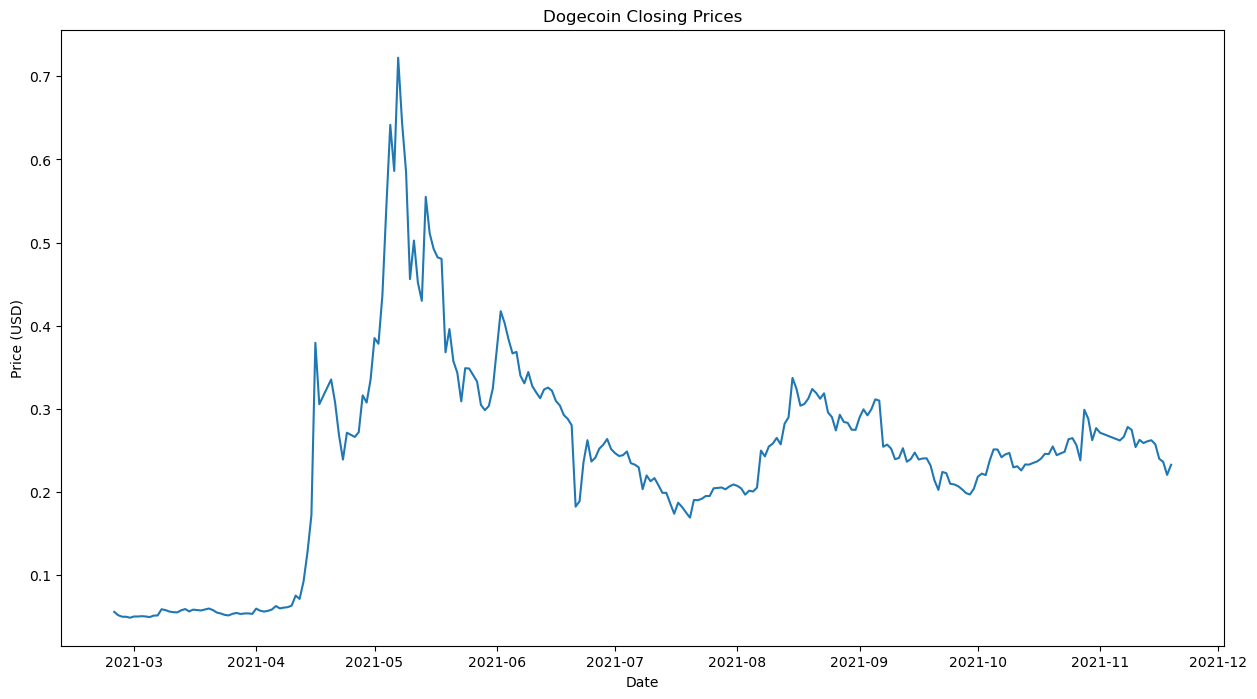

In [19]:
# Closing price plot
plt.figure(figsize=(15,8))
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Dogecoin Closing Prices')
plt.show()

In [20]:
# Calculate 7-day and 30-day moving averages
df['ma7'] = df['close'].rolling(7).mean()
df['ma30'] = df['close'].rolling(30).mean()

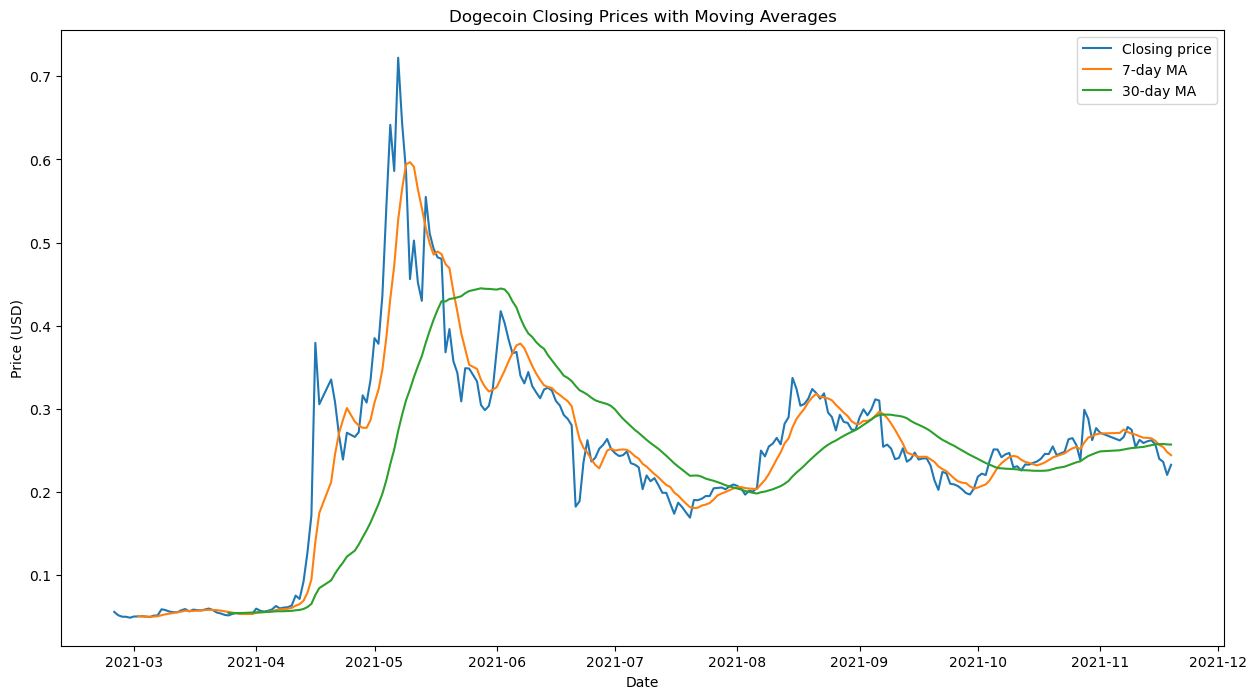

In [21]:
# Closing price plot with moving averages
plt.figure(figsize=(15,8))
plt.plot(df['date'], df[['close', 'ma7', 'ma30']])
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Dogecoin Closing Prices with Moving Averages')
plt.legend(['Closing price', '7-day MA', '30-day MA'])
plt.show()

In [22]:
# Extract months
df['month'] = df['date'].dt.strftime('%Y-%m')
df[['date', 'month']].head()

,date,month
0,2021-02-24,2021-02
1,2021-02-25,2021-02
2,2021-02-26,2021-02
3,2021-02-27,2021-02
4,2021-02-28,2021-02


In [23]:
# Calculate monthly Telegram sentiment totals
tel_df = df.groupby('month')[['negative_telegrams', 'neutral_telegrams', 'positive_telegrams']].sum()
tel_df = tel_df.rename(columns={'negative_telegrams':'Negative', 'neutral_telegrams':'Neutral', 'positive_telegrams':'Positive'})
tel_df

,Negative,Neutral,Positive
month,,,
2021-02,4,67,93
2021-03,14,243,142
2021-04,53,715,259
2021-05,123,1506,564
2021-06,14,396,85
2021-07,19,341,73
2021-08,13,320,968
2021-09,21,243,90
2021-10,9,174,60


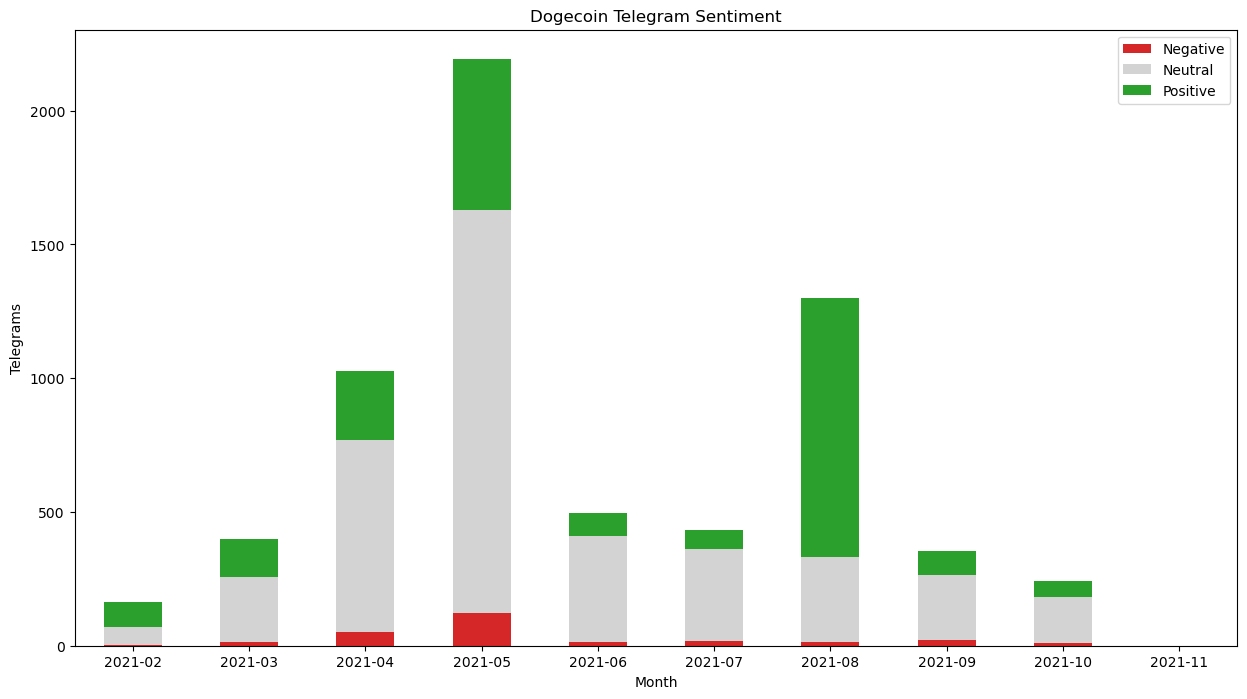

In [24]:
# Create Telegram sentiment stacked bar chart
tel_df.plot(kind='bar',
            stacked=True,
            color=['tab:red', 'lightgrey', 'tab:green'],
            figsize=(15,8))
plt.xlabel('Month')
plt.xticks(rotation='horizontal')
plt.ylabel('Telegrams')
plt.title('Dogecoin Telegram Sentiment')
plt.show()

In [25]:
# Calculate monthly Twitter sentiment totals
twt_df = df.groupby('month')[['negative_tweets', 'neutral_tweets', 'positive_tweets']].sum()
twt_df = twt_df.rename(columns={'negative_tweets':'Negative', 'neutral_tweets':'Neutral', 'positive_tweets':'Positive'})
twt_df

,Negative,Neutral,Positive
month,,,
2021-02,1721,32079,11015
2021-03,5324,117508,49770
2021-04,3446,67878,22673
2021-05,59229,760733,249779
2021-06,12905,217454,114053
2021-07,14453,277887,122660
2021-08,10632,254717,94950
2021-09,8483,184161,58530
2021-10,14116,275845,79182


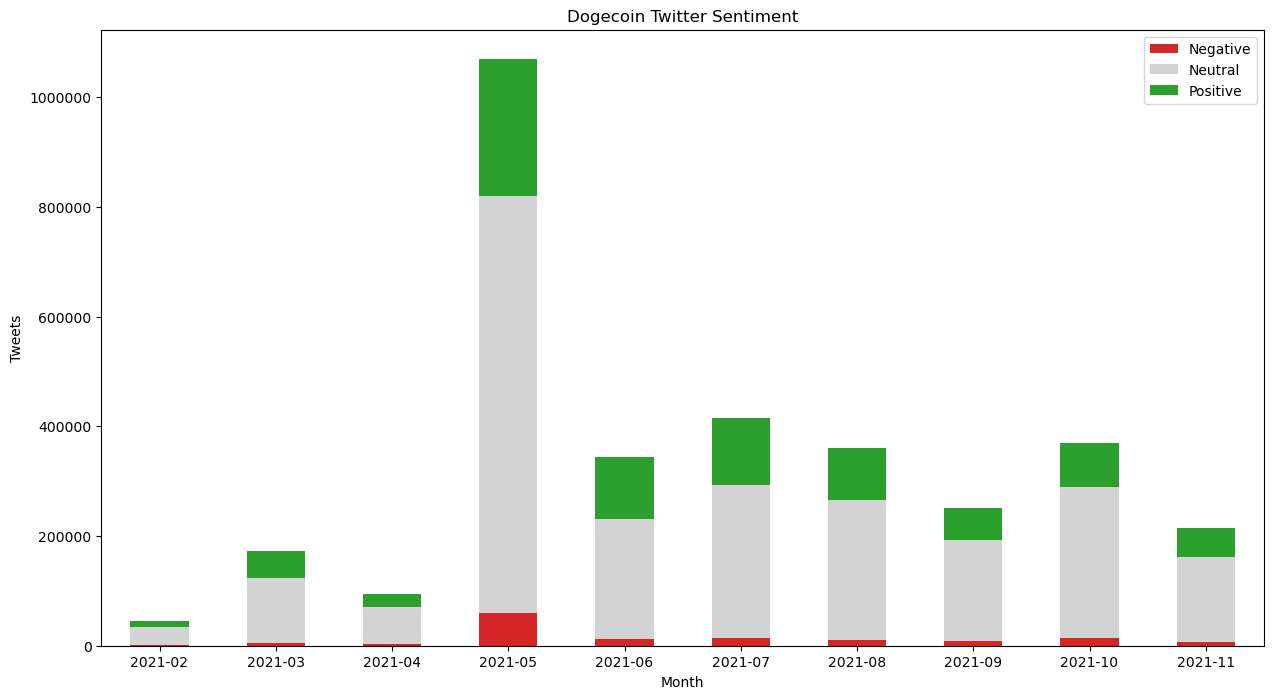

In [26]:
# Create Twitter sentiment stacked bar chart
twt_df.plot(kind='bar',
            stacked=True,
            color=['tab:red', 'lightgrey', 'tab:green'],
            figsize=(15,8))
plt.xlabel('Month')
plt.xticks(rotation='horizontal')
plt.ylabel('Tweets')
plt.ticklabel_format(axis='y', style='plain')
plt.title('Dogecoin Twitter Sentiment')
plt.show()

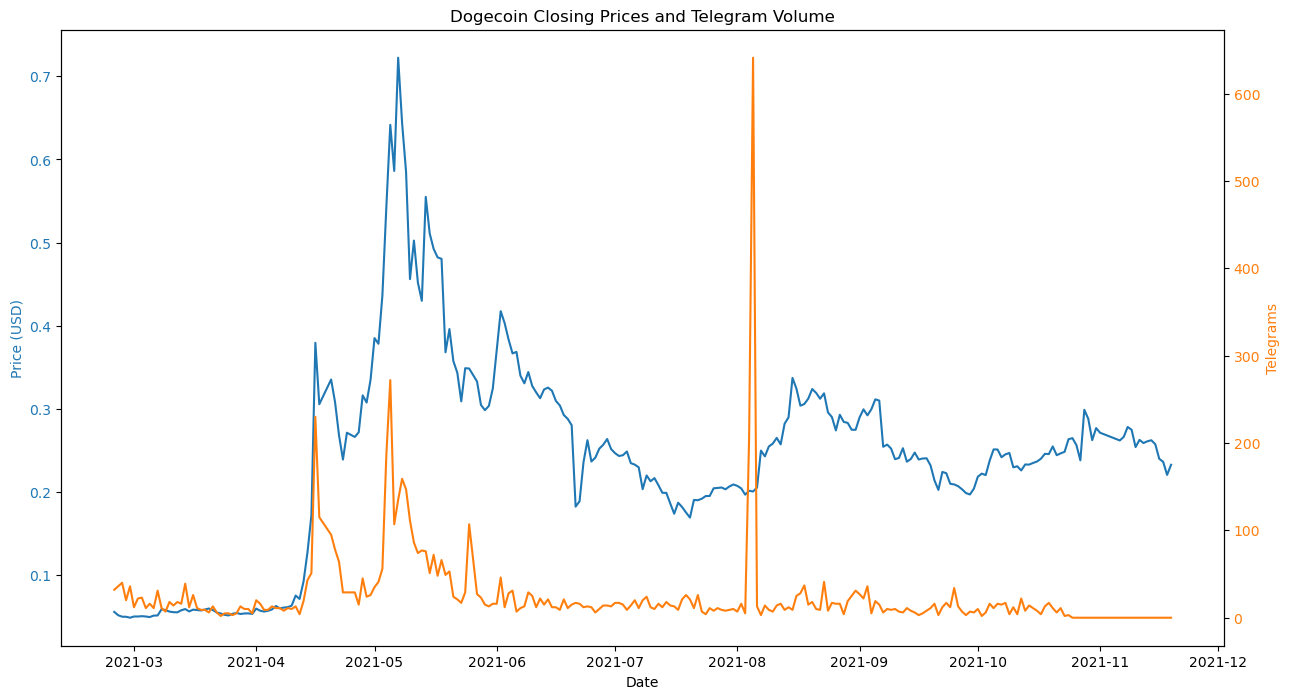

In [27]:
# Closing price and Telegram volume plot
fig, ax_left = plt.subplots(figsize=(15,8))

ax_left.set_xlabel('Date')
ax_left.set_ylabel('Price (USD)', color='tab:blue')
ax_left.plot(df['date'], df['close'], color='tab:blue')
ax_left.tick_params(axis='y', labelcolor='tab:blue')

ax_right = ax_left.twinx()
ax_right.set_ylabel('Telegrams', color='tab:orange')
ax_right.plot(df['date'], df['telegram_volume'], color='tab:orange')
ax_right.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Dogecoin Closing Prices and Telegram Volume')
plt.show()

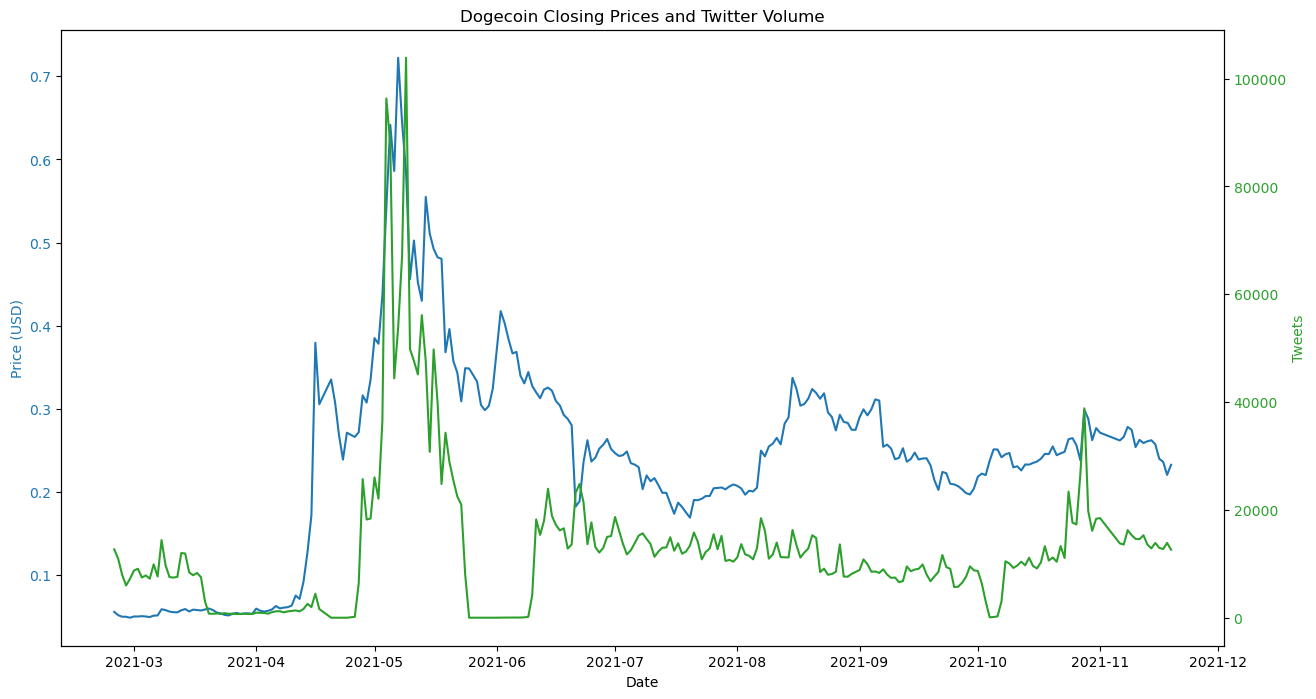

In [28]:
# Closing price and Twitter volume plot
fig, ax_left = plt.subplots(figsize=(15,8))

ax_left.set_xlabel('Date')
ax_left.set_ylabel('Price (USD)', color='tab:blue')
ax_left.plot(df['date'], df['close'], color='tab:blue')
ax_left.tick_params(axis='y', labelcolor='tab:blue')

ax_right = ax_left.twinx()
ax_right.set_ylabel('Tweets', color='tab:green')
ax_right.plot(df['date'], df['twitter_volume'], color='tab:green')
ax_right.tick_params(axis='y', labelcolor='tab:green')

plt.title('Dogecoin Closing Prices and Twitter Volume')
plt.show()

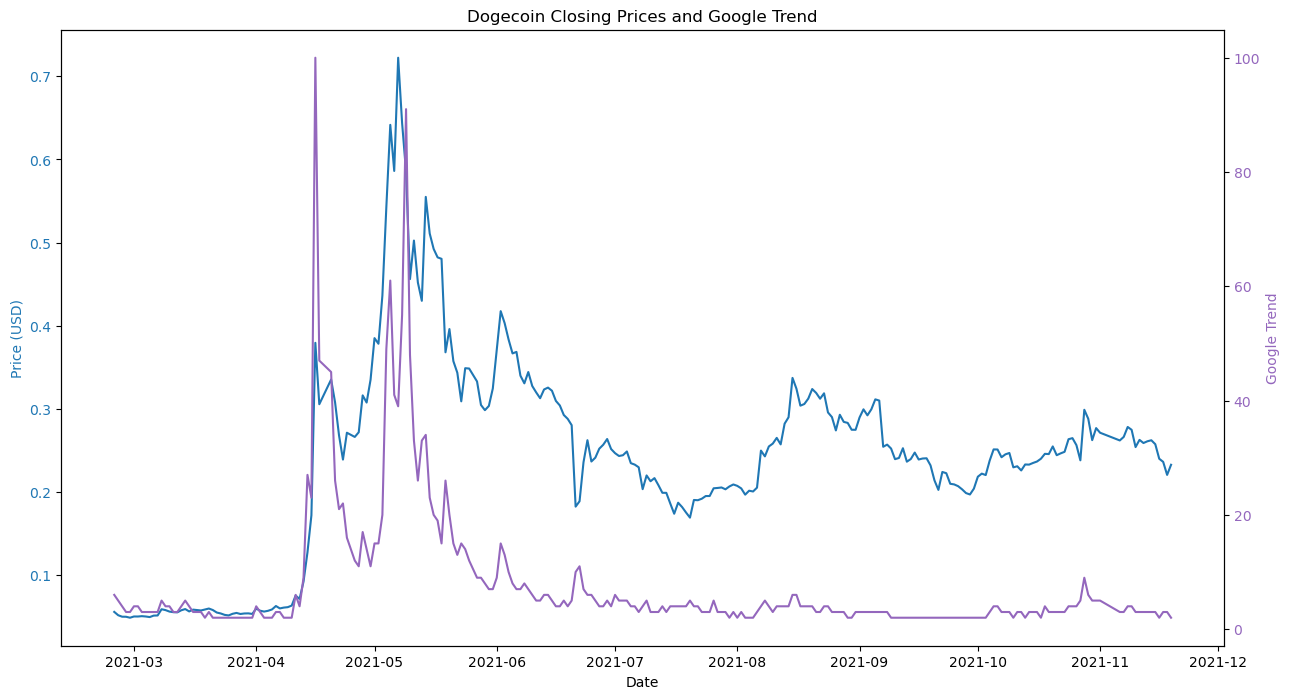

In [29]:
# Closing price and Google Trends plot
fig, ax_left = plt.subplots(figsize=(15,8))

ax_left.set_xlabel('Date')
ax_left.set_ylabel('Price (USD)', color='tab:blue')
ax_left.plot(df['date'], df['close'], color='tab:blue')
ax_left.tick_params(axis='y', labelcolor='tab:blue')

ax_right = ax_left.twinx()
ax_right.set_ylabel('Google Trend', color='tab:purple')
ax_right.plot(df['date'], df['google_trend'], color='tab:purple')
ax_right.tick_params(axis='y', labelcolor='tab:purple')

plt.title('Dogecoin Closing Prices and Google Trend')
plt.show()

# Part 3: Modeling

In [30]:
# Import libraries
import statsmodels.api as sm
import pylab

In [31]:
# Calculate Pearson correlation coefficients
df[['telegram_volume', 'twitter_volume', 'google_trend', 'close']].corr(method='pearson')

,telegram_volume,twitter_volume,google_trend,close
telegram_volume,1.000000,0.387158,0.543738,0.336537
twitter_volume,0.387158,1.000000,0.626289,0.635229
google_trend,0.543738,0.626289,1.000000,0.587993
close,0.336537,0.635229,0.587993,1.000000


Based on the findings of [Abraham et al.](https://scholar.smu.edu/datasciencereview/vol1/iss3/1/) social media sentiment is assumed to be less important than sheer Telegram / Twitter volume for predicting Dogecoin prices. However, for our dataset, the correlation matrix shows that Telegram volume is not strongly correlated with Dogecoin closing prices (r=0.337). Hence, only Twitter volume and Google Trend data are used as inputs in the linear regression model.

In [32]:
# Create training dataset
training = df[df['date'] < '2021-10-01']
training = training[['date', 'twitter_volume', 'google_trend', 'close']]
training.tail()

,date,twitter_volume,google_trend,close
210,2021-09-26,5743,2,0.207164
211,2021-09-27,6481,2,0.203380
212,2021-09-28,7574,2,0.198867
213,2021-09-29,9532,2,0.197171
214,2021-09-30,8785,2,0.204229


In [33]:
# Create test dataset
test = df[df['date'] >= '2021-10-01']
test = test[['date', 'twitter_volume', 'google_trend', 'close']]
test.head()

,date,twitter_volume,google_trend,close
215,2021-10-01,8682,2,0.218528
216,2021-10-02,6362,2,0.222242
217,2021-10-03,3003,2,0.220533
218,2021-10-04,83,3,0.237848
219,2021-10-05,135,4,0.251368


In [34]:
# Verify percentages allocated to training/test datasets
print(len(training)/len(df))
print(len(test)/len(df))

0.8237547892720306
0.17624521072796934


In [35]:
# Create linear regression model
predictors = sm.add_constant(training[['twitter_volume', 'google_trend']], prepend=False)
model = sm.OLS(training['close'], predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     95.39
Date:                Mon, 19 Jun 2023   Prob (F-statistic):           2.84e-30
Time:                        19:15:10   Log-Likelihood:                 199.32
No. Observations:                 215   AIC:                            -392.6
Df Residuals:                     212   BIC:                            -382.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
twitter_volume  3.862e-06   5.76e-07      6.704      0.000    2.73e-06       5e-06
google_trend       0.0032      0.001      4.960      0.000       0.002       0.005
const              0.1615      0.009     18.539      0.000       0.144       0.179
==============================================================================
Omnibus:                        7.604   Durbin-Watson:                   0.245
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                4.648
Skew:                          -0.183   Prob(JB):                       0.0979
Kurtosis:                       2.380   Cond. No.                     2.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Looking at the individual F-test p-values, all parameters in the linear regression model are statistically significant at the standard 5% significance level. However, the R-squared value 0.474 is not very good (only 47% of the variance in Dogecoin closing prices is accounted for by the model).

In [36]:
# Training data predictions
training_dates = training['date']
training_predictions = model.predict(training[['twitter_volume', 'google_trend', 'close']])
print(training_dates[:10], training_predictions[:10])

0   2021-02-24
1   2021-02-25
2   2021-02-26
3   2021-02-27
4   2021-02-28
5   2021-03-01
6   2021-03-02
7   2021-03-03
8   2021-03-04
9   2021-03-05
Name: date, dtype: datetime64[ns] 0    0.077360
1    0.066800
2    0.051821
3    0.040866
4    0.045472
5    0.054887
6    0.056094
7    0.046720
8    0.048099
9    0.045665
dtype: float64


In [37]:
# Test data predictions
test_dates = test['date']
test_predictions = model.predict(test[['twitter_volume', 'google_trend', 'close']])
print(test_dates[:10], test_predictions[:10])

215   2021-10-01
216   2021-10-02
217   2021-10-03
218   2021-10-04
219   2021-10-05
220   2021-10-06
221   2021-10-07
222   2021-10-08
223   2021-10-09
224   2021-10-10
Name: date, dtype: datetime64[ns] 215    0.075268
216    0.066908
217    0.053660
218    0.048402
219    0.054010
220    0.054435
221    0.060481
222    0.089715
223    0.088421
224    0.079238
dtype: float64


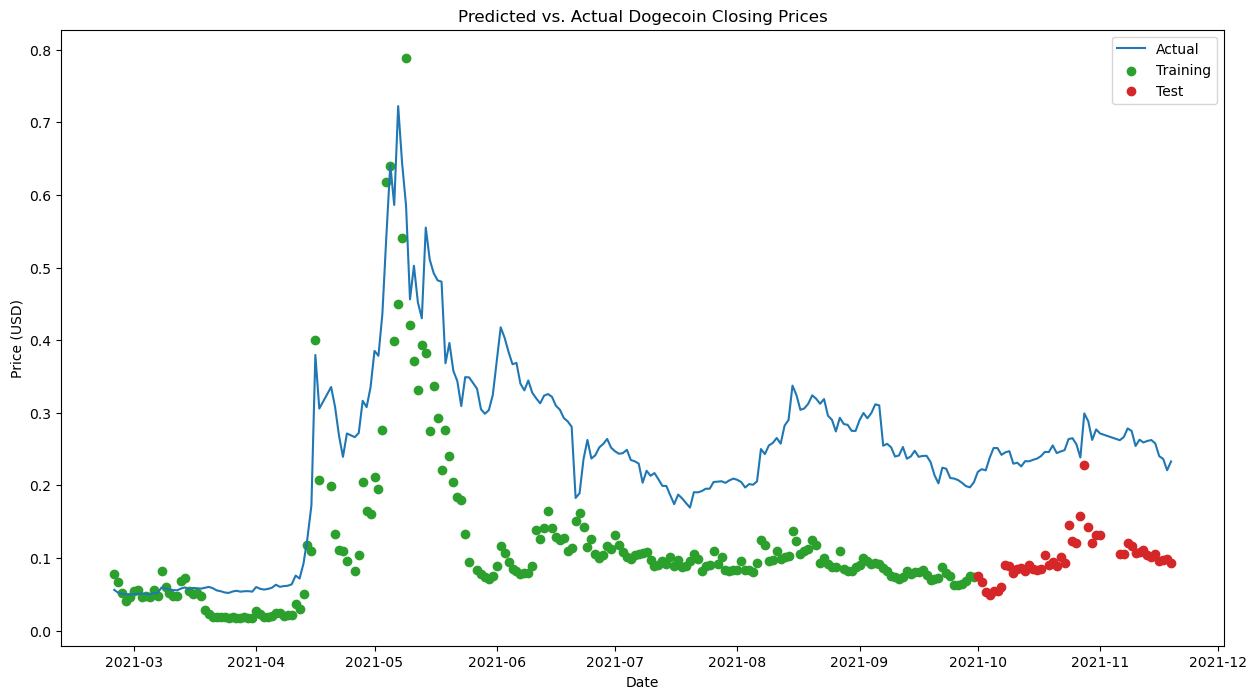

In [38]:
# Plot predicted versus actual prices
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df['date'], df['close'])
ax.scatter(training_dates, training_predictions, color='tab:green')
ax.scatter(test_dates, test_predictions, color='tab:red')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.set_title('Predicted vs. Actual Dogecoin Closing Prices')
ax.legend(['Actual', 'Training', 'Test'])
plt.show()

The linear regression model captures the general trends in Dogecoin closing prices but appears to be undervaluing the currency for a lot of the year 2021.

In [39]:
# Residuals
training['predictions'] = training_predictions
training['residuals'] = training['predictions'] - training['close']
training.head()

,date,twitter_volume,google_trend,close,predictions,residuals
0,2021-02-24,12682,6,0.056001,0.077360,0.021360
1,2021-02-25,10950,5,0.051987,0.066800,0.014813
2,2021-02-26,7980,4,0.050215,0.051821,0.001606
3,2021-02-27,5981,3,0.050144,0.040866,-0.009278
4,2021-02-28,7222,3,0.048988,0.045472,-0.003516


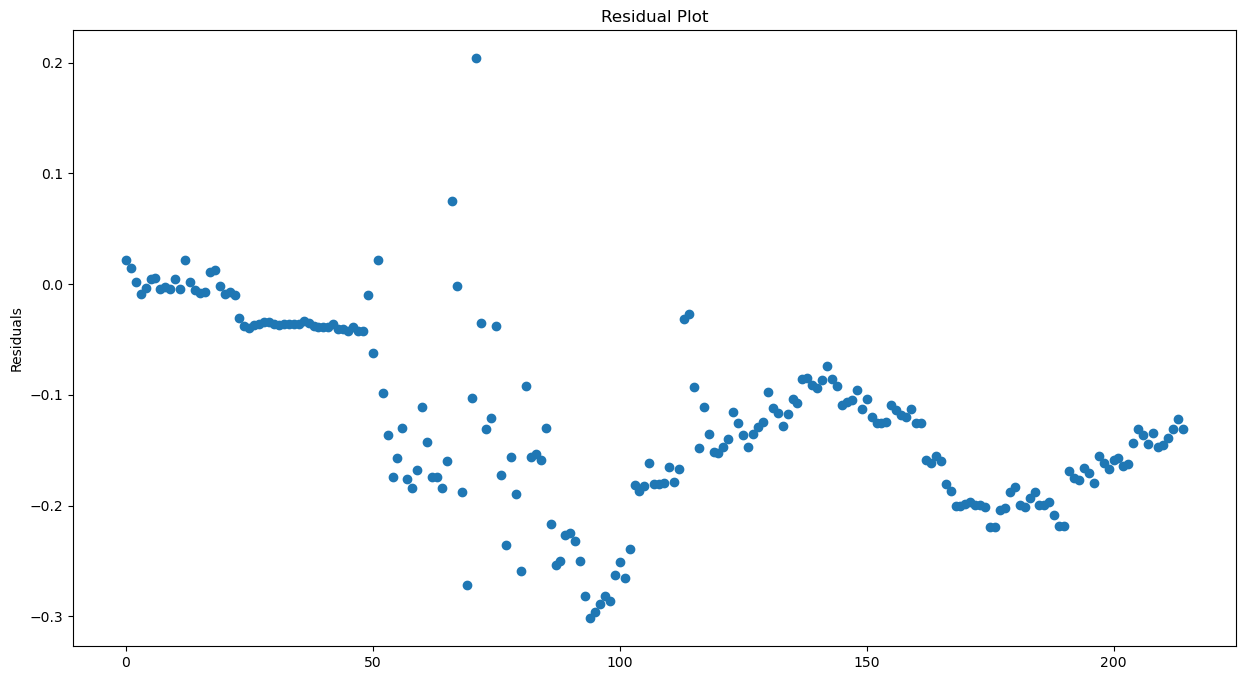

In [40]:
# Residual plot
plt.figure(figsize=(15,8))
plt.scatter(training.index, training['residuals'])
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The errors in the residual plot are not randomly scattered about zero with constant variance. Instead, the residuals appear to be time dependent, fluctuating in accordance with the closing prices of Dogecoin across the year 2021. Linear regression assumes that residuals are normally distributed with zero mean and constant variance. Further analysis of the modeling technique is needed.

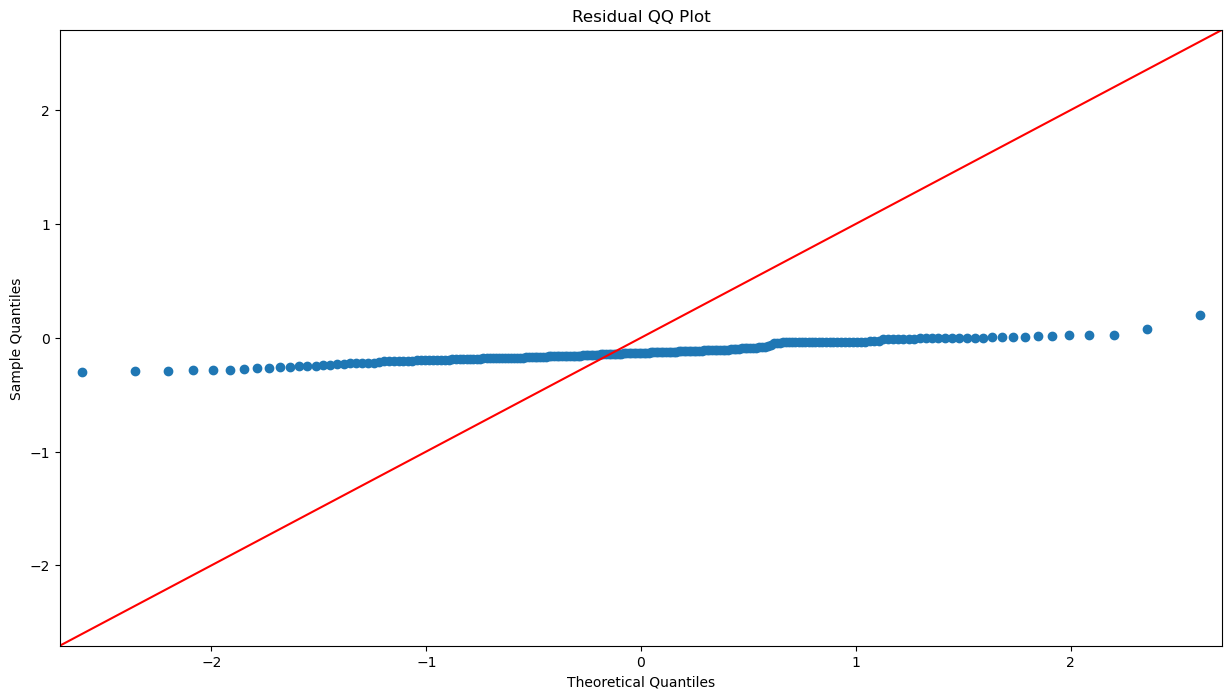

In [41]:
# Residual QQ plot
fig, ax = plt.subplots(figsize=(15,8))
sm.qqplot(training['residuals'], line='45', ax=ax)
ax.set_title('Residual QQ Plot')
pylab.show()

The residual QQ plot indicates that the residuals are not normally distributed (they do not fall along the $y=x$ line representing a perfect match between the sample distribution and a normal distribution). Again, linear regression assumes that the residuals are normally distributed with zero mean and constant variance, so a different modeling technique may need to be considered.